In [7]:
import os.path as op
import sys
sys.path.append(op.abspath('../'))

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import models
import var, fcts

from project import files, defs, col, normalize
from lib import data, plot as lp, bdt as lBDT

import hdbscan

In [9]:
N = 100000
S = 100000
P = 100000


shift_pedestal = (600, 150)
amp_S = 30  # (25, 5)
std_N = 1.

# Peaked
n_peaks = (1, 6)  # between 1 and 6 peaks / event
amp_P = (1, 30)  # peak amplitude between 1 and 15
length_peaks = (1, 3)  # length of a peak between 1 and 3

shift_pedestal = (600, 150)

optimised = False

components = {
    "S": {"S": S, "amp_S": amp_S},
    "N": {"N": N, "std_N": std_N},
    "P": {
        "P": P, "n_peaks": n_peaks,
        "amp_P": amp_P, "length_peaks": length_peaks
    }
}

bdt_name = "BDT_SNP"

image_path = op.join(var.image_path, bdt_name)

In [10]:
rng = np.random.default_rng(12345)

dataframe = models.get_full_dataframe(
    components,
    shift_pedestal=shift_pedestal,
    random_time_shift=True,
    rng=rng
)


In [11]:
norm_df = normalize.normalise_df(dataframe)
norm_df = files.compute_voi(
    norm_df,
    ['mean','std'])
norm_df

Time taken: 0.24035215377807617
Time taken: 0.22524666786193848


s0        s1        s2        s3        s4        s5        s6  \
0     -0.033501  0.234509  0.234509 -0.033501  2.646600  3.986650  1.038539   
1     -0.213201 -0.213201  1.492405  1.492405  1.492405  0.639602 -0.213201   
2     -0.170114  0.737162 -0.170114  0.737162  2.551716 -0.170114 -0.170114   
3      0.917663 -1.835326  1.835326  2.752989  0.000000  0.917663  0.000000   
4      0.006939  0.228996  2.893671  4.003953  1.339277  0.006939 -0.215117   
...         ...       ...       ...       ...       ...       ...       ...   
99995 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199   
99996  1.483240  1.483240  1.483240  1.483240 -0.674200 -0.674200 -0.674200   
99997 -0.529150 -0.529150 -0.529150 -0.529150 -0.529150 -0.529150 -0.529150   
99998 -0.179605 -0.179605 -0.179605 -0.179605 -0.179605 -0.179605 -0.179605   
99999 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199   

             s7        s8        s9  ...       s30       s31      amp_S  \
0      0.234509  0.234509 -0.837532  ... -0.033501 -0.301511  15.632668   
1     -0.213201  0.639602 -0.213201  ...  0.639602 -0.213201   2.877307   
2     -0.170114  0.737162  0.737162  ... -0.170114 -1.077391   1.175563   
3     -0.917663  0.000000  0.000000  ...  0.917663  0.917663   2.567312   
4     -0.881286 -0.215117 -0.881286  ...  0.006939 -0.215117  19.995979   
...         ...       ...       ...  ...       ...       ...        ...   
99995 -0.258199 -0.258199 -0.258199  ... -0.258199 -0.258199        NaN   
99996 -0.674200 -0.674200 -0.674200  ...  1.483240 -0.674200        NaN   
99997 -0.529150  1.889822  1.889822  ... -0.529150  1.889822        NaN   
99998 -0.179605 -0.179605 -0.179605  ... -0.179605 -0.179605        NaN   
99999 -0.258199 -0.258199 -0.258199  ... -0.258199 -0.258199        NaN   

       is_sig  is_noise  is_peaked    old_mean    old_std          mean  std  
0        True     False      False   562.12500   3.731203 -5.551115e-17  1.0  
1        True     False      False   563.25000   1.172604  6.331741e-17  1.0  
2        True     False      False  1004.18750   1.102200  4.163336e-17  1.0  
3        True     False      False   569.00000   1.089725 -6.938894e-18  1.0  
4        True     False      False   746.96875   4.503362 -1.474515e-17  1.0  
...       ...       ...        ...         ...        ...           ...  ...  
99995   False     False       True   639.62500   2.420615  3.469447e-18  1.0  
99996   False     False       True   600.06250   6.025661  1.387779e-17  1.0  
99997   False     False       True   397.46875  10.334966  3.469447e-17  1.0  
99998   False     False       True   798.93750   5.219779  6.418477e-17  1.0  
99999   False     False       True   650.81250   7.019782  4.510281e-17  1.0  

[300000 rows x 40 columns]

In [6]:
samples_columns = defs.list_samples_columns + ['mean','std','old_mean','old_std']
df_for_clustering = norm_df[samples_columns]

In [46]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = 500, min_samples = 1, cluster_selection_epsilon = 3)
clusterer.fit(df_for_clustering)

HDBSCAN(cluster_selection_epsilon=3, min_cluster_size=500, min_samples=1)

In [47]:
df_for_clustering['hdbscan'] = clusterer.labels_

In [48]:
df_for_clustering['is_sig'] = norm_df['is_sig']
df_for_clustering['is_peaked'] = norm_df['is_peaked']
df_for_clustering['is_noise'] = norm_df['is_noise']

In [49]:
def get_edges_from_cats(cats):
    cats = np.unique(cats)
    mini = min(cats)
    maxi = max(cats)
    nb = len(cats)
    return np.linspace(mini - 0.5, maxi + 0.5, nb+1, endpoint=True)

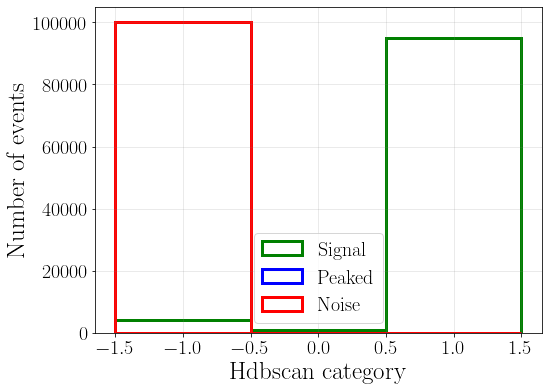

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))
cats = ["S", "P", "N"]

edges = get_edges_from_cats(df_for_clustering["hdbscan"])
for cat in cats:
    dataframe_mixed_cat = df_for_clustering.query(
        f"{var.dict_df_flags[cat]}==True"
    )
    lp.plot_hist(
        dataframe_mixed_cat["hdbscan"],
        "Hdbscan category",
        label=var.dict_df_labels[cat],
        fc=(0, 0, 0, 0),
        edgecolor=var.dict_df_colors[cat],
        ax=ax,
        bins=edges,
        lw=3
    )

ax.legend()

In [53]:
df_for_clustering

s0        s1        s2        s3        s4        s5        s6  \
0      0.000000  0.834058  0.834058  0.000000  0.834058  2.502173 -0.834058   
1     -0.059435 -0.059435  2.929309  3.744421  1.570789  0.212269 -0.331139   
2     -0.142974  0.772059 -0.142974  0.772059  2.602125 -0.142974 -0.142974   
3      0.227292 -0.525123  2.986147  3.989366  1.230512  0.227292 -0.274318   
4      0.042095  0.491110  2.736185  4.083230  0.940125 -0.406920 -0.406920   
...         ...       ...       ...       ...       ...       ...       ...   
99995 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199   
99996  1.483240  1.483240  1.483240  1.483240 -0.674200 -0.674200 -0.674200   
99997 -0.529150 -0.529150 -0.529150 -0.529150 -0.529150 -0.529150 -0.529150   
99998 -0.179605 -0.179605 -0.179605 -0.179605 -0.179605 -0.179605 -0.179605   
99999 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199   

             s7        s8        s9  ...          mean  std    old_mean  \
0      0.834058  1.668115 -0.834058  ...  6.938894e-18  1.0   562.00000   
1     -0.602843 -0.331139 -0.602843  ... -6.353425e-17  1.0   563.21875   
2     -0.142974  0.772059  0.772059  ... -4.163336e-17  1.0  1004.15625   
3     -0.775928 -0.525123 -0.525123  ... -8.673617e-18  1.0   569.09375   
4     -0.855935  0.042095 -0.855935  ... -5.030698e-17  1.0   746.90625   
...         ...       ...       ...  ...           ...  ...         ...   
99995 -0.258199 -0.258199 -0.258199  ...  3.469447e-18  1.0   639.62500   
99996 -0.674200 -0.674200 -0.674200  ...  1.387779e-17  1.0   600.06250   
99997 -0.529150  1.889822  1.889822  ...  3.469447e-17  1.0   397.46875   
99998 -0.179605 -0.179605 -0.179605  ...  6.418477e-17  1.0   798.93750   
99999 -0.258199 -0.258199 -0.258199  ...  4.510281e-17  1.0   650.81250   

         old_std  hdbscan  is_sig  is_peaked  is_noise      amp_S  pos_max  
0       1.198958        1    True      False     False   2.488448        5  
1       3.680475        1    True      False     False  15.713896        3  
2       1.092857        1    True      False     False   1.283721        4  
3       3.987162        1    True      False     False  17.242654        3  
4       2.227097        1    True      False     False  10.216342        3  
...          ...      ...     ...        ...       ...        ...      ...  
99995   2.420615       -1   False       True     False        NaN       10  
99996   6.025661       -1   False       True     False        NaN        0  
99997  10.334966       -1   False       True     False        NaN        8  
99998   5.219779       -1   False       True     False        NaN       22  
99999   7.019782       -1   False       True     False        NaN       15  

[300000 rows x 42 columns]

In [54]:
files.compute_voi(df_for_clustering, ['pos_max'])

Time taken: 0.20949220657348633


s0        s1        s2        s3        s4        s5        s6  \
0      0.000000  0.834058  0.834058  0.000000  0.834058  2.502173 -0.834058   
1     -0.059435 -0.059435  2.929309  3.744421  1.570789  0.212269 -0.331139   
2     -0.142974  0.772059 -0.142974  0.772059  2.602125 -0.142974 -0.142974   
3      0.227292 -0.525123  2.986147  3.989366  1.230512  0.227292 -0.274318   
4      0.042095  0.491110  2.736185  4.083230  0.940125 -0.406920 -0.406920   
...         ...       ...       ...       ...       ...       ...       ...   
99995 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199   
99996  1.483240  1.483240  1.483240  1.483240 -0.674200 -0.674200 -0.674200   
99997 -0.529150 -0.529150 -0.529150 -0.529150 -0.529150 -0.529150 -0.529150   
99998 -0.179605 -0.179605 -0.179605 -0.179605 -0.179605 -0.179605 -0.179605   
99999 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199 -0.258199   

             s7        s8        s9  ...          mean  std    old_mean  \
0      0.834058  1.668115 -0.834058  ...  6.938894e-18  1.0   562.00000   
1     -0.602843 -0.331139 -0.602843  ... -6.353425e-17  1.0   563.21875   
2     -0.142974  0.772059  0.772059  ... -4.163336e-17  1.0  1004.15625   
3     -0.775928 -0.525123 -0.525123  ... -8.673617e-18  1.0   569.09375   
4     -0.855935  0.042095 -0.855935  ... -5.030698e-17  1.0   746.90625   
...         ...       ...       ...  ...           ...  ...         ...   
99995 -0.258199 -0.258199 -0.258199  ...  3.469447e-18  1.0   639.62500   
99996 -0.674200 -0.674200 -0.674200  ...  1.387779e-17  1.0   600.06250   
99997 -0.529150  1.889822  1.889822  ...  3.469447e-17  1.0   397.46875   
99998 -0.179605 -0.179605 -0.179605  ...  6.418477e-17  1.0   798.93750   
99999 -0.258199 -0.258199 -0.258199  ...  4.510281e-17  1.0   650.81250   

         old_std  hdbscan  is_sig  is_peaked  is_noise      amp_S  pos_max  
0       1.198958        1    True      False     False   2.488448        5  
1       3.680475        1    True      False     False  15.713896        3  
2       1.092857        1    True      False     False   1.283721        4  
3       3.987162        1    True      False     False  17.242654        3  
4       2.227097        1    True      False     False  10.216342        3  
...          ...      ...     ...        ...       ...        ...      ...  
99995   2.420615       -1   False       True     False        NaN       10  
99996   6.025661       -1   False       True     False        NaN        0  
99997  10.334966       -1   False       True     False        NaN        8  
99998   5.219779       -1   False       True     False        NaN       22  
99999   7.019782       -1   False       True     False        NaN       15  

[300000 rows x 42 columns]

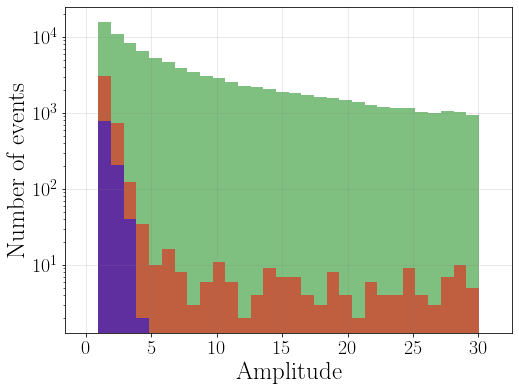

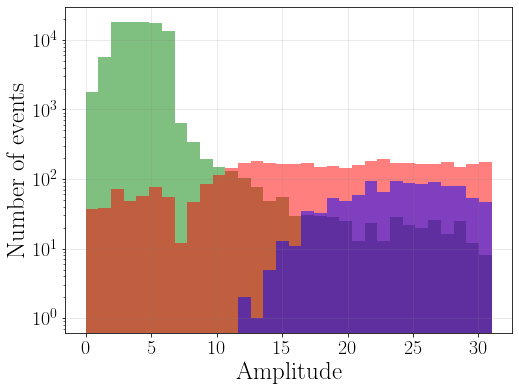

In [56]:
df_for_clustering['amp_S'] = norm_df['amp_S']
df_1 = df_for_clustering.query('hdbscan == 1 and is_sig == True')
df_neg = df_for_clustering.query('hdbscan == -1 and is_sig == True')
df_0 = df_for_clustering.query('hdbscan == 0 and is_sig == True')

for variable in ['amp_S', 'pos_max']:
    
    min_max = (0, 31)
    
    fig, ax = lp.plot_hist(
        df_1[variable], "Amplitude",
        color='g',
        alpha=0.5,
        min_max = min_max,
        bins=32
    )

    lp.plot_hist(
        df_neg[variable], "Amplitude",
        ax=ax,
        color='r',
        alpha=0.5, logscale=True,
        min_max = min_max,
        bins=32
    )
    lp.plot_hist(
        df_0[variable], "Amplitude",
        ax=ax,
        color='b',
        alpha=0.5, logscale=True,
        min_max = min_max,
        bins=32
    )